## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms.v2 as transforms
import numpy as np

from data import plot_examples, split_dataset, transform_to_tensor, transform_crop_and_resize, transform_res_net_18, transform_mnasnet_0_75, plt
from model import PneumoniaDetectionResNet18Model, PneumoniaDetectionMobileNetV3LargeModel, PneumoniaDetectionMNASNet0_75Model
from trainer import Trainer
from datetime import datetime

In [2]:
# Global Parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

allow_restnet18_training = False
resnet18_model_path = "checkpoints/2023_12_06_PneumoniaDetectionResNet18Model.pth"

allow_mobile_v3_large_training = False
mobile_v3_large_model_path = "checkpoints/2023_12_06_PneumoniaDetectionMobileNetV3LargeModel.pth"

allow_mnasnet_0_75_training = True
mnasnet_0_75_model_path = None

## 2. Dataset

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [3]:
train_set = torchvision.datasets.ImageFolder(root="data/train", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
validation_set = torchvision.datasets.ImageFolder(root="data/val", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))
merged_dataset = ConcatDataset([train_set, validation_set])
train_set, validation_set = split_dataset(merged_dataset, 0.7)

test_set = torchvision.datasets.ImageFolder(root="data/test", transform=transforms.Compose([transform_to_tensor, transform_crop_and_resize]))

classes = test_set.classes
print(f"Classes: {test_set.class_to_idx}")

Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


<Figure size 1200x700 with 0 Axes>

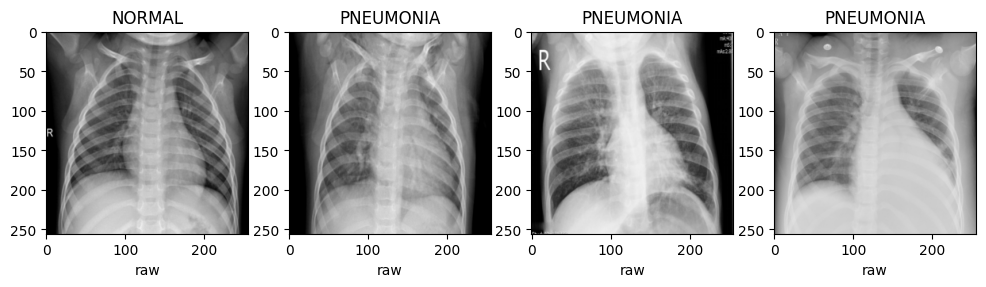

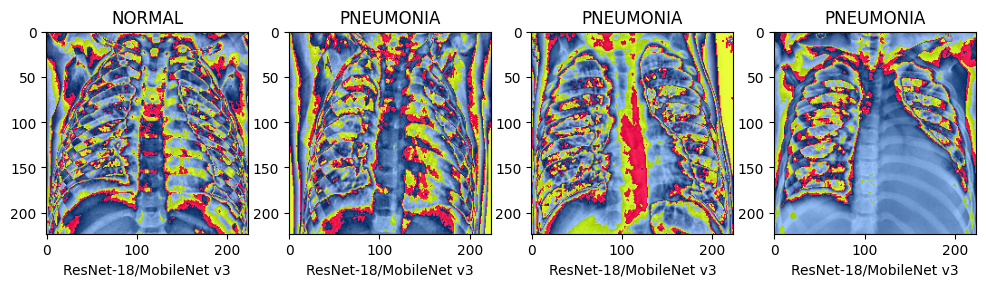

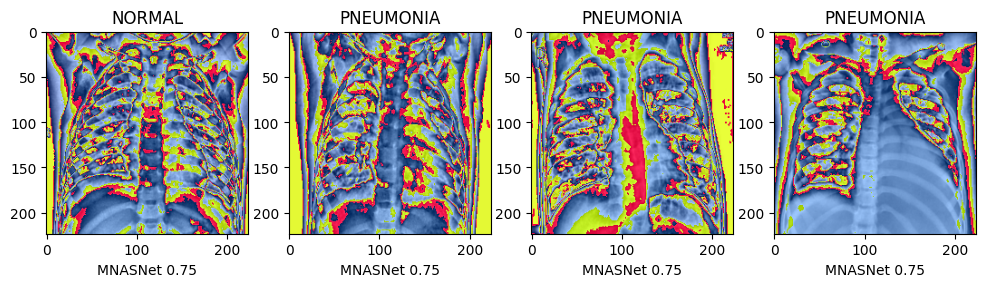

In [5]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
test_loader = DataLoader(test_set, batch_size=batch_size)

dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure(figsize=(12, 7))
plot_examples("raw", images, labels, classes, transform_crop_and_resize)
plot_examples("ResNet-18/MobileNet v3", images, labels, classes, transform_res_net_18)
plot_examples("MNASNet 0.75", images, labels, classes, transform_mnasnet_0_75)
plt.show()

## 3. Model

### 3.1 ResNet-18

In [5]:
resnet18_model = PneumoniaDetectionResNet18Model()
print(resnet18_model)

PneumoniaDetectionResNet18Model(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

### 3.2 MobileNet v3

In [6]:
mobile_v3_large_model = PneumoniaDetectionMobileNetV3LargeModel()
print(mobile_v3_large_model)

PneumoniaDetectionMobileNetV3LargeModel(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[232]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias

### 3.3 MNASNet 0.75

In [7]:
mnasnet_0_75_model = PneumoniaDetectionMNASNet0_75Model()
print(mnasnet_0_75_model)

PneumoniaDetectionMNASNet0_75Model(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[232]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (backbone): MNASNet(
    (layers): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
      (8): Sequential(
        (0): _InvertedResidual(
          

## 4. Train

In [8]:
loss_fn = nn.CrossEntropyLoss()

### 4.1 ResNet-18

In [9]:
adam_optimizer = optim.Adam(resnet18_model.parameters(), lr=0.00001)
resnet18_trainer = Trainer(resnet18_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=3)

In [10]:
if allow_restnet18_training:
    resnet18_trainer.fit()

    # save model and training history
    resnet18_model.set_history(resnet18_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({ 
        "state_dict": resnet18_model.state_dict(),
        "history": resnet18_model.history
    }, 
    f"checkpoints/{today}_{resnet18_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(resnet18_model_path)
    resnet18_model.load_state_dict(checkpoint['state_dict'])
    resnet18_model.set_history(checkpoint['history'])
    resnet18_trainer.set_history(resnet18_model.history)

### 4.2 MobileNet v3

In [11]:
adam_optimizer = optim.Adam(mobile_v3_large_model.parameters(), lr=0.00001)
mobile_v3_large_trainer = Trainer(mobile_v3_large_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=8)

In [12]:
if allow_mobile_v3_large_training:
    mobile_v3_large_trainer.fit()

    # save model and training history
    mobile_v3_large_model.set_history(mobile_v3_large_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({
        "state_dict": mobile_v3_large_model.state_dict(),
        "history": mobile_v3_large_model.history
    }, f"checkpoints/{today}_{mobile_v3_large_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(mobile_v3_large_model_path)
    mobile_v3_large_model.load_state_dict(checkpoint["state_dict"])
    mobile_v3_large_model.set_history(checkpoint["history"])
    mobile_v3_large_trainer.set_history(mobile_v3_large_model.history)

### 4.3 MNASNet 0.75

In [13]:
adam_optimizer = optim.Adam(mnasnet_0_75_model.parameters())
mnasnet_0_75_trainer = Trainer(mnasnet_0_75_model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=20)

In [14]:
if allow_mnasnet_0_75_training:
    mnasnet_0_75_trainer.fit()

    # save model and training history
    mnasnet_0_75_model.set_history(mnasnet_0_75_trainer.get_history())
    today = datetime.today().strftime("%Y_%m_%d")
    torch.save({
        "state_dict": mnasnet_0_75_model.state_dict(),
        "history": mnasnet_0_75_model.history
    }, f"checkpoints/{today}_{mnasnet_0_75_model.__class__.__name__}.pth")
else:
    # load model and training history
    checkpoint = torch.load(mnasnet_0_75_model)
    mnasnet_0_75_model.load_state_dict(checkpoint["state_dict"])
    mnasnet_0_75_model.set_history(checkpoint["history"])
    mnasnet_0_75_trainer.set_history(mnasnet_0_75_model.history)

/Users/paulopacitti/.pyenv/versions/3.11.2/lib/python3.11/site-packages/torch/nn/functional.py:4010: UserWarning: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corners, scale_factors)


Epoch [1/20], Step [0/115], Loss: 0.7152
Epoch [1/20], Step [10/115], Loss: 0.3701
Epoch [1/20], Step [20/115], Loss: 0.4634
Epoch [1/20], Step [30/115], Loss: 0.2610
Epoch [1/20], Step [40/115], Loss: 0.2679
Epoch [1/20], Step [50/115], Loss: 0.3208
Epoch [1/20], Step [60/115], Loss: 0.2393
Epoch [1/20], Step [70/115], Loss: 0.2276
Epoch [1/20], Step [80/115], Loss: 0.1941
Epoch [1/20], Step [90/115], Loss: 0.2553
Epoch [1/20], Step [100/115], Loss: 0.3003
Epoch [1/20], Step [110/115], Loss: 0.1968
Epoch [1/20], Validation Loss: 0.5098
Epoch [2/20], Step [0/115], Loss: 0.2432
Epoch [2/20], Step [10/115], Loss: 0.1891
Epoch [2/20], Step [20/115], Loss: 0.2293
Epoch [2/20], Step [30/115], Loss: 0.2133
Epoch [2/20], Step [40/115], Loss: 0.2179
Epoch [2/20], Step [50/115], Loss: 0.2734
Epoch [2/20], Step [60/115], Loss: 0.2213
Epoch [2/20], Step [70/115], Loss: 0.1099
Epoch [2/20], Step [80/115], Loss: 0.2383
Epoch [2/20], Step [90/115], Loss: 0.1655
Epoch [2/20], Step [100/115], Loss: 0.

## 5. Evaluation

### 5.1 ResNet-18

Train accuracy: 0.9923539161682129
Train f1 score: 0.9923539161682129
Validation accuracy: 0.9866241812705994
Validation f1 score: 0.9866241812705994


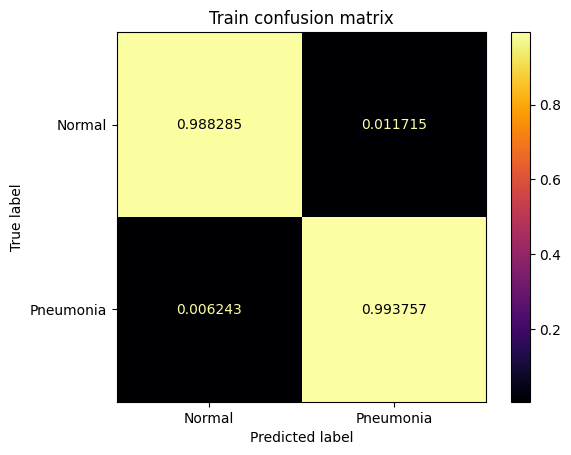

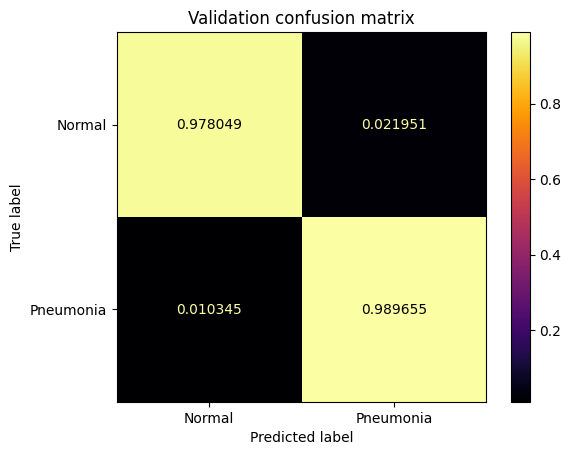

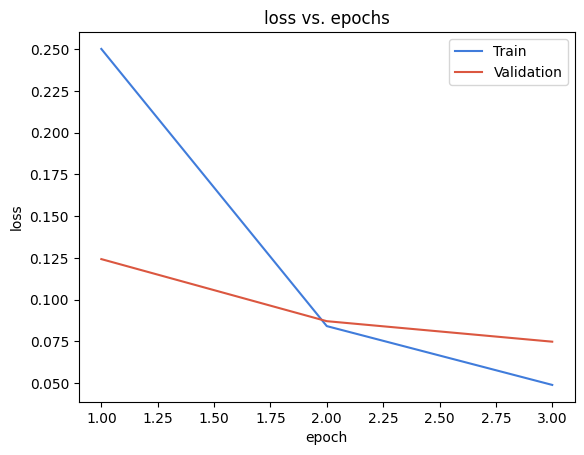

In [19]:
if allow_restnet18_training:
    resnet18_trainer.evaluate()
    resnet18_trainer.plot_loss()

### 5.2 MobileNet v3

Train accuracy: 0.9879847168922424
Train f1 score: 0.9879847168922424
Validation accuracy: 0.9821656346321106
Validation f1 score: 0.9821656346321106


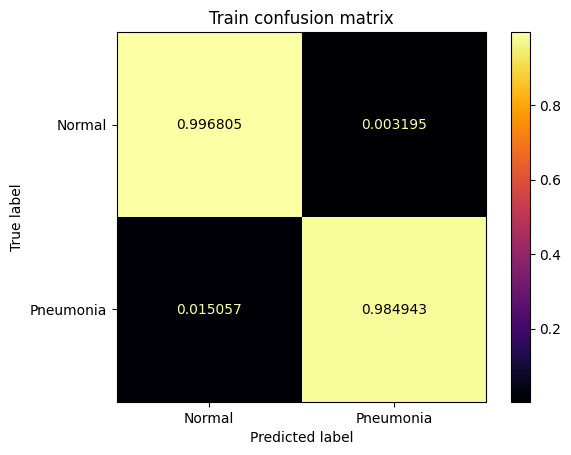

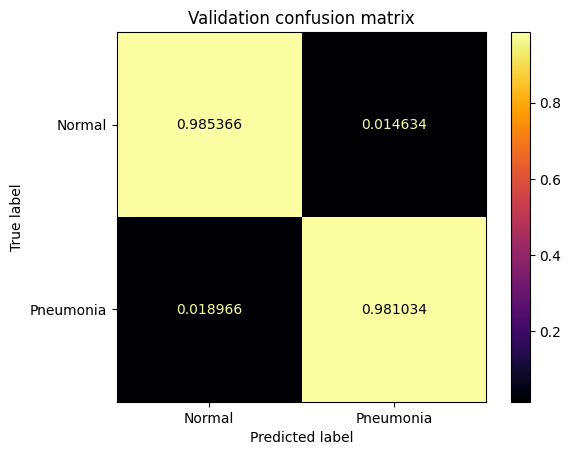

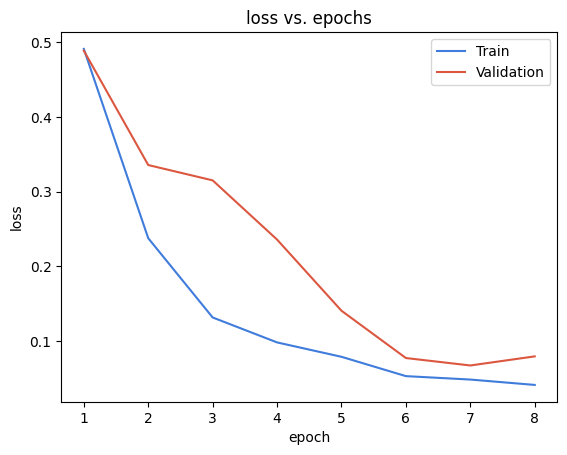

In [18]:
if allow_mobile_v3_large_training:
    mobile_v3_large_trainer.evaluate()
    mobile_v3_large_trainer.plot_loss()

### 5.3 MNASNet 0.75

Train accuracy: 0.8151283264160156
Train f1 score: 0.8151283264160156
Validation accuracy: 0.8140127658843994
Validation f1 score: 0.8140127658843994


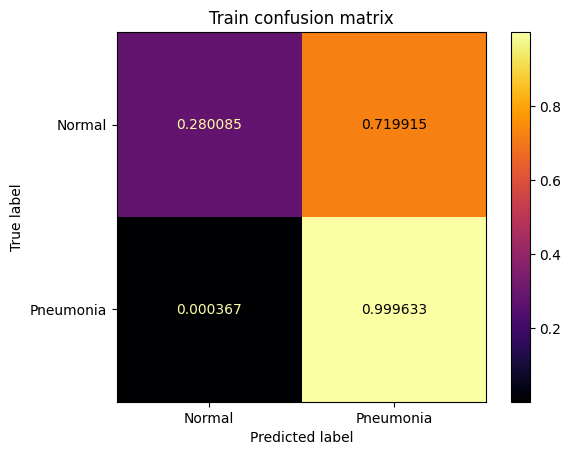

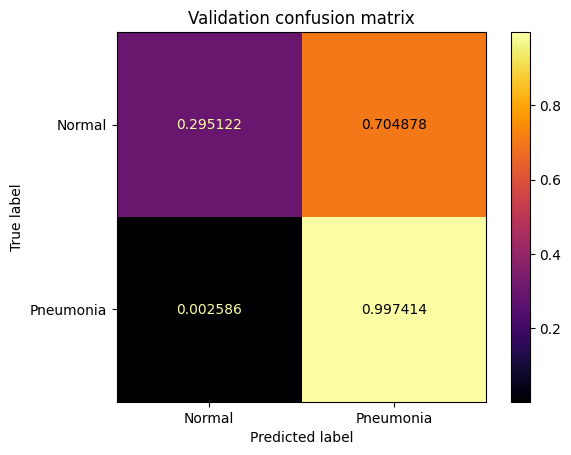

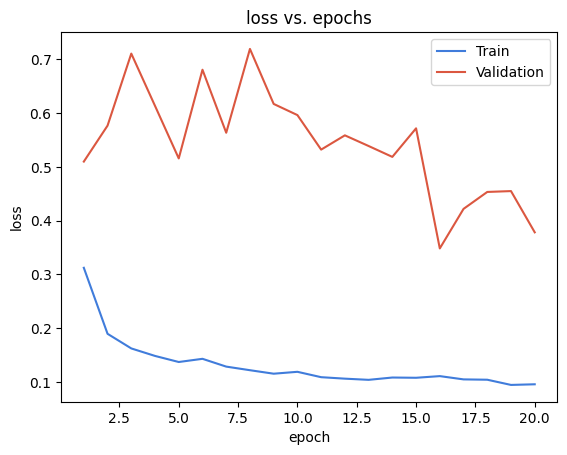

In [17]:
if allow_mnasnet_0_75_training:
    mnasnet_0_75_trainer.evaluate()
    mnasnet_0_75_trainer.plot_loss()